In [3]:
import bambi as bmb
import pandas as pd
import numpy as np
import pymc3 as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# Load and examine American National Election Studies (ANES) data
These data are from the 2016 pilot study. The full study consisted of 1200 people, but here we've selected the subset of 487 people who responded to a question about whether they would vote for Hillary Clinton or Donald Trump. 

In [4]:
data = pd.read_csv('data/ANES_2016_pilot.csv')
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Our outcome variable is `vote`, which gives peoples' responses to the following question prompt:

*"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"*

In [3]:
data['vote'].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

The two predictors we'll examine are a respondent's `age` and their political party affiliation, `party_id`, which is their response to the following question prompt:

*"Generally speaking, do you usually think of yourself as a Republican, a Democrat, an
independent, or what?"*

In [4]:
data['party_id'].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

These two predictors are somewhat correlated, but not all that much:

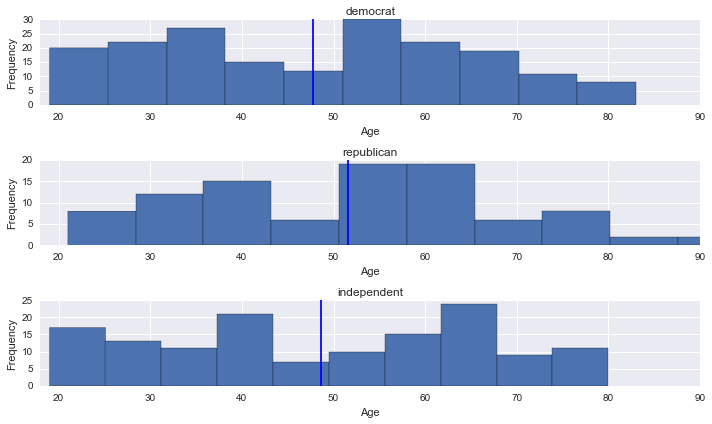

In [16]:
fig, ax = plt.subplots(3, figsize=(10,6))
key = dict(zip(data['party_id'].unique(),range(3)))
for label, df in data.groupby('party_id'):
    ax[key[label]].hist(df['age'])
    ax[key[label]].set_xlim([18,90])
    ax[key[label]].set_xlabel('Age')
    ax[key[label]].set_ylabel('Frequency')
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df['age'].mean())
plt.tight_layout()

We can get a pretty clear idea of how party identification is related to voting intentions by just looking at a contingency table for these two variables:

In [17]:
pd.crosstab(data['vote'], data['party_id'])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


But our main question here will be: How is respondent age related to voting intentions, and is this relationship different for different party affiliations? For this we will need logistic regression.

# `clinton_model`

To keep this simple, let's look at only the data from people who indicated that they would vote for either Clinton or Trump, and we'll model the probability of voting for Clinton.

In [5]:
clinton_data = data.loc[data['vote'].isin(['clinton','trump']),:]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Specifying and fitting the model is simple. Notice the (optional) syntax that we use on the left-hand-side of the formula: We say `vote[clinton]` to instruct bambi that we wish the model the probability that `vote=='clinton'`, rather than the probability that `vote=='trump'`. If we leave this unspecified, bambi will just pick one of the events to model, but will inform you which one it picked when you build the model (and again when you look at model summaries.) 

When fitting models using the `pymc3` backend, the default estimation strategy is to get some initial parameter estimates using variational methods (ADVI), and then to use those estimates to initialize the MCMC chains. This generally works quite well, but occasionally in models with non-Normal responses, the ADVI initialization will fail. That's what was happening for this particular data set and model, so below we disable the ADVI initialization by changing from `init='advi'` (the default) to `init=None`, which tells the `pymc3` backend to jump straight to the MCMC sampling.

In [9]:
clinton_model = bmb.Model(clinton_data)
clinton_fitted = clinton_model.fit('vote[clinton] ~ party_id + party_id:age',
    family='bernoulli', samples=1000, chains=4, init=None)

/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:266: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:212: UserWarning: Modeling the probability that vote=='clinton'
  self.y.name, str(self.data[self.y.name].iloc[event])))
//anaconda/envs/python3/lib/python3.5/site-packages/theano/tensor/basic.py:2144: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Assigned NUTS to Intercept
INFO:pymc3:Assigned NUTS to Intercept
Assigned NUTS to party_id
INFO:pymc3:Assigned NUTS to party_id
Assigned NUTS to party_id:age
INFO:pymc3:Assigned NUTS to party_id:age
100%|██████████| 1000/1000 [00:21<00:00, 47.34it/s]


Since we didn't explicitly set any of the prior distributions, here's a view of what the default priors look like for all parameters:

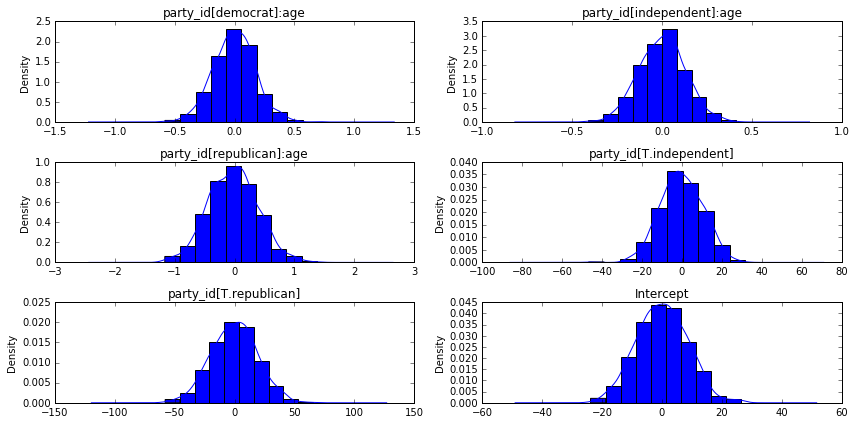

In [10]:
_ = clinton_model.plot()

In [24]:
{x.name:x.prior.args for x in clinton_model.terms.values()}

{'Intercept': {'mu': array([ 0.308043]), 'sd': array([ 8.39859892])},
 'party_id': {'mu': array([0, 0]), 'sd': array([ 10.51415445,  18.72417819])},
 'party_id:age': {'mu': array([0, 0, 0]),
  'sd': array([ 0.16748696,  0.12909332,  0.40771782])}}

Some more info about these default priors can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

Now let's check out the the results!

/Users/Jake/Desktop/Google Drive/bambi/bambi/results.py:246: UserWarning: Modeling the probability that vote=='clinton'
  str(self.model.data[self.model.y.name][event])))


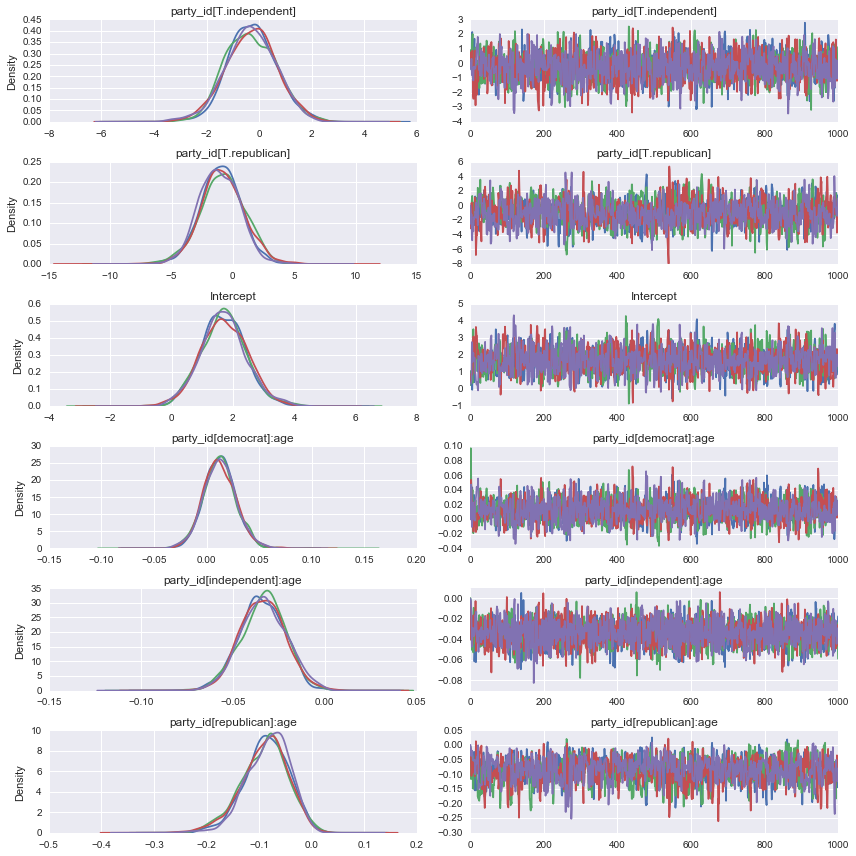

In [25]:
_ = clinton_fitted.plot()

In [11]:
clinton_fitted.summary()

/Users/Jake/Desktop/Google Drive/bambi/bambi/results.py:333: UserWarning: Modeling the probability that vote=='clinton'
  str(self.model.data[self.model.y.name][event])))


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
party_id[democrat]:age,0.012925,0.015476,-0.017382,0.042967,1291,0.999738
party_id[independent]:age,-0.033213,0.012117,-0.056611,-0.009553,2863,1.001154
party_id[republican]:age,-0.087261,0.042251,-0.174315,-0.011447,1261,1.000304
party_id[T.independent],-0.305958,0.973585,-2.271088,1.490759,1388,1.000051
party_id[T.republican],-0.908806,1.744601,-4.325952,2.493946,1265,1.000412
Intercept,1.689076,0.744569,0.274339,3.140384,1162,1.000121


# Inferential stuff

Grab the posteriors samples of the `age` slopes for the three `party_id` categories.

In [30]:
parties = ['democrat','independent','republican']
dem, ind, rep = [clinton_fitted.to_df()['party_id[{}]:age'.format(x)] for x in parties]

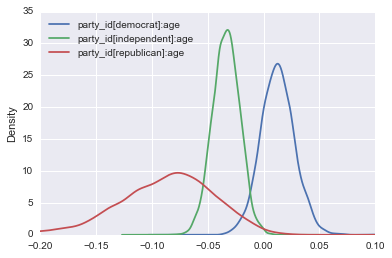

In [43]:
for x in [dem, ind, rep]:
    x.plot(kind='kde', xlim=[-.2, .1])
plt.legend(loc='upper left')

What is the probability that the Democrat slope is greater than the Republican slope?

In [31]:
(dem > rep).mean()

0.99350000000000005

Probability that the Democrat slope is greater than the Independent slope?

In [32]:
(dem > ind).mean()

0.99224999999999997

Probability that the Independent slope is greater than the Republican slope?

In [47]:
(ind > rep).mean()

0.89449999999999996

Probability that the Democrat slope is greater than 0?

In [48]:
(dem > 0).mean()

0.79774999999999996

Probability that the Republican slope is less than 0?

In [49]:
(rep < 0).mean()

0.99175000000000002

Probability that the Independent slope is less than 0?

In [51]:
(ind < 0).mean()

0.99815789473684213

# Spaghetti plot of model predictions

Grab all the MCMC samples.

In [50]:
trace_df = clinton_fitted.to_df()
trace_df.head()

,Intercept,party_id[T.independent],party_id[T.republican],party_id[democrat]:age,party_id[independent]:age,party_id[republican]:age
0,0.267859,-0.046265,-0.090188,0.002663,-0.000242,-0.004201
1,0.267859,-0.046265,-0.090188,0.002663,-0.000242,-0.004201
2,0.258777,-0.280157,-1.207309,0.018140,-0.002618,-0.016465
3,0.264963,-0.419551,-1.365685,0.032801,-0.007864,-0.019855
4,0.675864,-0.389874,-1.410841,0.039368,-0.013406,-0.036133


Separate this into two DataFrames, one containing the intercept for each `party_id`, the other containing the `age` slopes for each `party_id`.

In [54]:
slopes = trace_df.iloc[:,-3:]
intercepts = pd.DataFrame({
        'dem': trace_df['Intercept'],
        'ind': trace_df['Intercept'] + trace_df['party_id[T.independent]'],
        'rep': trace_df['Intercept'] + trace_df['party_id[T.republican]']
    })

Compute the predicted values for each posterior sample.

In [55]:
def invlogit(x): return 1/(1+np.exp(-x))
X = np.hstack([np.array([1]*len(np.arange(18, 91)))[:,None],
               np.arange(18, 91)[:,None]])
yhat = [invlogit(np.dot(X, np.vstack([intercepts.iloc[:,i], slopes.iloc[:,i]])))
        for i in range(3)]

Make the plot!

(18, 90)

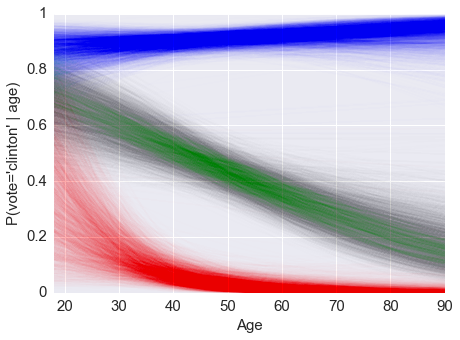

In [57]:
fig, axes = plt.subplots(figsize=(7,5))

cols = ['b','g','r']
for i in range(3):
    for t in range(len(trace_df.index)):
        axes.plot(X[:,1], yhat[i][:,t], alpha=.005, color=cols[i])
axes.set_ylabel('P(vote=\'clinton\' | age)', fontsize=15)
axes.set_xlabel('Age', fontsize=15)
axes.set_yticklabels([0,.2,.4,.6,.8,1], fontsize=15)
axes.set_xticklabels([10,20,30,40,50,60,70,80,90], fontsize=15)
axes.set_xlim(18, 90)